In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import GPy
from PEP_reg import PEP
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import time
from utils import calculate_metric
from sklearn.cluster import KMeans
from sklearn.model_selection import KFold
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import GPy
from pathlib import Path

In [5]:
# Configuration
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"
OUTPUT_PATH = '../output/Exact_GP'

In [8]:
# create path
output_dir = Path(OUTPUT_PATH)
output_dir.mkdir(parents=True, exist_ok=True)

In [9]:
# Set random seed
np.random.seed(42)

In [10]:
# Load data
train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

print("Training data shape:", train_features.shape)
print("Test data shape:", test_features.shape)

Training data shape: (1293, 317)
Test data shape: (432, 317)


In [11]:
# Get feature lists
feature_list = train_features.columns
category_features = train_features.select_dtypes(include=['bool']).columns
non_category_features = [i for i in feature_list if i not in category_features]

print("Number of categorical features:", len(category_features))
print("Number of numerical features:", len(non_category_features))

Number of categorical features: 164
Number of numerical features: 153


In [12]:
# Prepare data
scaler = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), non_category_features)
    ],
    remainder='passthrough'  # Leave categorical features untouched
)

# Scale the features
X_train_scaled = scaler.fit_transform(train_features)
X_test_scaled = scaler.transform(test_features)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(train_labels.values)
y_test = y_scaler.transform(test_labels.values)

In [13]:
# Model parameters
input_dim = X_train_scaled.shape[1]  # Number of features

# Initialize kernel with ARD
k = GPy.kern.RBF(input_dim=input_dim, ARD=True)

# Create sparse GP model with PEP inference
model = GPy.models.GPRegression(X_train_scaled, y_train, kernel=k)

print("Initial model parameters:")
print(model)

Initial model parameters:

Name : GP regression
Objective : 1812.8609377580535
Number of Parameters : 319
Number of Optimization Parameters : 319
Updates : True
Parameters:
  GP_regression.           |   value  |  constraints  |  priors
  rbf.variance             |     1.0  |      +ve      |        
  rbf.lengthscale          |  (317,)  |      +ve      |        
  Gaussian_noise.variance  |     1.0  |      +ve      |        


In [14]:
# Train the model
start_time = time.time()

# Optimize with multiple restarts to avoid local minima
model.optimize_restarts(num_restarts=5, messages=True, max_iters=1000)

elapsed_time = time.time() - start_time
print(f"\nTraining time: {elapsed_time:.3f} seconds")

print("\nOptimized model parameters:")
print(model)

Optimization restart 1/5, f = 1464.3233546010342


Optimization restart 2/5, f = 1474.898245258798


Optimization restart 3/5, f = 1409.850988739733


 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 4/5, f = 1475.1443884663558


Optimization restart 5/5, f = 1470.9829602925415

Training time: 3852.537 seconds

Optimized model parameters:

Name : GP regression
Objective : 1409.850988739733
Number of Parameters : 319
Number of Optimization Parameters : 319
Updates : True
Parameters:
  GP_regression.           |                value  |  constraints  |  priors
  rbf.variance             |   0.9217040528807188  |      +ve      |        
  rbf.lengthscale          |               (317,)  |      +ve      |        
  Gaussian_noise.variance  |  0.15830070359565918  |      +ve      |        


In [15]:
def predict(model, X_new, X_scaler, y_scaler):
    X_scaled = X_scaler.transform(X_new)
    mean, var = model.predict(X_scaled)
    mean = y_scaler.inverse_transform(mean)
    var = var * (y_scaler.scale_ ** 2)
    return mean, var

In [16]:
# Make predictions
mean_train, var_train = predict(model, train_features, scaler, y_scaler)
mean_test, var_test = predict(model, test_features, scaler, y_scaler)

# Calculate metrics for training data
train_mae, train_mape, train_rmse, train_rsqr = calculate_metric(
    mean_train, train_labels['rr1_30'].values
)

# Calculate metrics for test data
test_mae, test_mape, test_rmse, test_rsqr = calculate_metric(
    mean_test, test_labels['rr1_30'].values
)

print("Training Metrics:")
print(f"Mean Absolute Error: {train_mae:.4f}")
print(f"Mean Absolute Percentage Error: {train_mape:.4f}")
print(f"Root Mean Square Error: {train_rmse:.4f}")
print(f"R-squared: {train_rsqr:.4f}")

print("\nTest Metrics:")
print(f"Mean Absolute Error: {test_mae:.4f}")
print(f"Mean Absolute Percentage Error: {test_mape:.4f}")
print(f"Root Mean Square Error: {test_rmse:.4f}")
print(f"R-squared: {test_rsqr:.4f}")

Training Metrics:
Mean Absolute Error: 0.3549
Mean Absolute Percentage Error: 4638.7691
Root Mean Square Error: 0.0924
R-squared: 0.9212

Test Metrics:
Mean Absolute Error: 0.3428
Mean Absolute Percentage Error: 391.3132
Root Mean Square Error: 0.2245
R-squared: 0.5598


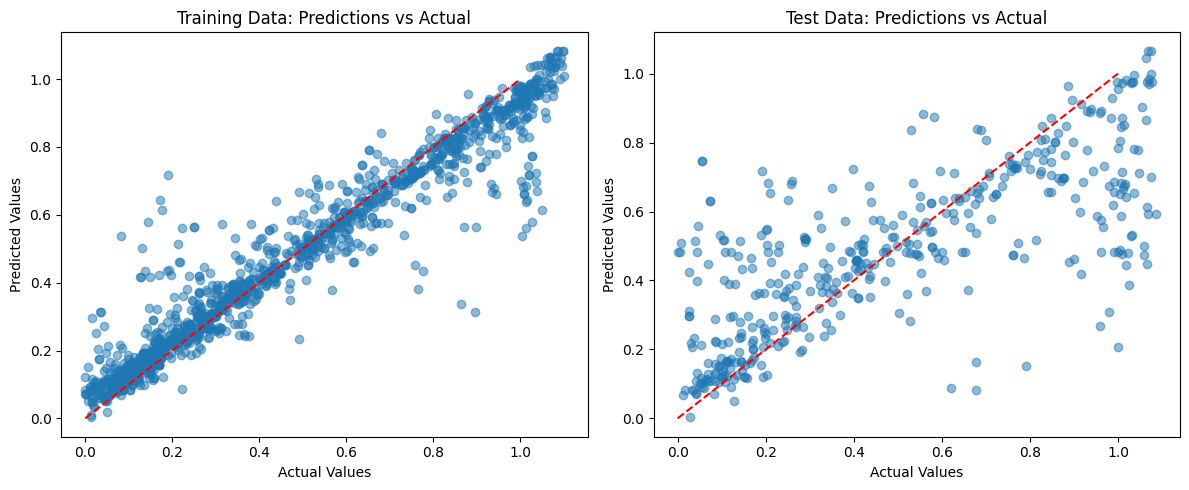

In [17]:
# Visualize predictions vs actual values
plt.figure(figsize=(12, 5))

# Training data
plt.subplot(1, 2, 1)
plt.scatter(train_labels['rr1_30'].values, mean_train, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data: Predictions vs Actual')

# Test data
plt.subplot(1, 2, 2)
plt.scatter(test_labels['rr1_30'].values, mean_test, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data: Predictions vs Actual')

plt.tight_layout()
plt.show()

In [18]:
np.sqrt(var_train.ravel()).shape

 /var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_58893/2452053174.py:1: RuntimeWarning:invalid value encountered in sqrt


(1293,)

In [19]:
train_labels['rr1_30'].shape

(1293,)

 /var/folders/gc/mln0kg89025flmz65rqz4qn40000gn/T/ipykernel_58893/3962992637.py:7: RuntimeWarning:invalid value encountered in sqrt


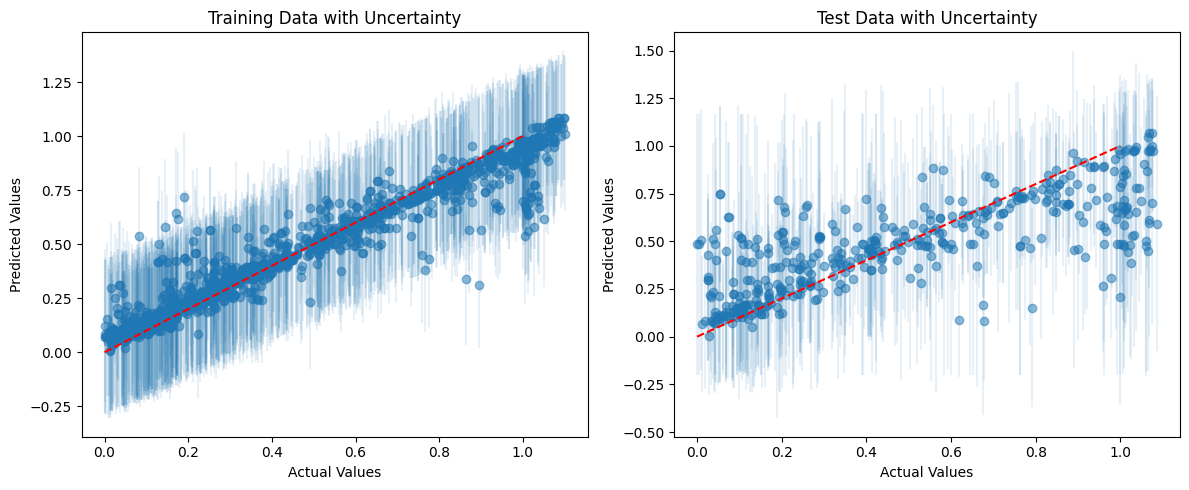

In [20]:
# Plot uncertainty estimates
plt.figure(figsize=(12, 5))

# Training data uncertainty
plt.subplot(1, 2, 1)
plt.errorbar(train_labels['rr1_30'].values, mean_train.ravel(), 
             yerr=2*np.sqrt(var_train.ravel()), fmt='none', alpha=0.1)
plt.scatter(train_labels['rr1_30'].values, mean_train, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Training Data with Uncertainty')

# Test data uncertainty
plt.subplot(1, 2, 2)
plt.errorbar(test_labels['rr1_30'].values, mean_test.ravel(), 
             yerr=2*np.sqrt(var_test.ravel()), fmt='none', alpha=0.1)
plt.scatter(test_labels['rr1_30'].values, mean_test, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Test Data with Uncertainty')

plt.tight_layout()
plt.show()

5-fold CV

In [21]:
features = pd.concat([train_features, test_features], axis=0, ignore_index=True)
features

,coupon rate,SP500 MD,Average daily 1-year SP500 return,Ratio to MA,US Corporate Bond Yield Spread,US Corporate Bond Yield Spread(3-5 year),US Corporate Bond Yield Spread(5-7 year),US Corporate Bond Yield Spread(7-10 year),US Corporate Bond Yield Spread(10+ year),US Generic Govt 3 Month Yield,...,event_type_subcategory_sum_Missing Coupon payment only,event_type_subcategory_sum_Missing Interest payment,event_type_subcategory_sum_Missing Loan payment,event_type_subcategory_sum_Missing Principal payment,event_type_subcategory_sum_Others,event_type_subcategory_sum_Pre-Negotiated Chapter 11,event_type_subcategory_sum_Protection,event_type_subcategory_sum_Receivership,event_type_subcategory_sum_Rehabilitation,event_type_subcategory_sum_Restructuring
0,7.500,-117.46020,-0.000189,125.407139,177.213028,134.012054,198.8153,191.364395,223.346344,0.1983,...,True,False,False,False,False,False,False,False,False,False
1,6.000,166.38276,0.000768,-4.603446,101.613617,77.032829,123.3998,105.932022,139.111115,0.0355,...,False,False,False,False,False,False,False,False,False,False
2,11.000,119.85752,0.000678,-11.950380,104.545959,77.416649,129.4317,111.818001,139.717407,0.0101,...,False,False,False,False,False,False,False,False,False,False
3,9.125,653.51208,0.001638,-2.494861,90.736633,64.654129,95.3731,92.141212,121.666237,0.0152,...,False,False,False,False,False,False,False,False,False,False
4,9.250,231.89472,0.000664,4.823413,98.533821,68.759308,93.4174,107.424469,139.741165,1.2865,...,False,False,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1720,3.250,147.33344,0.000556,3.538252,128.976395,95.360374,138.8445,138.946106,172.733887,0.0000,...,False,False,False,False,False,False,False,False,False,False
1721,10.000,175.31656,0.000554,-4.067337,121.170998,92.879501,123.2500,131.104904,162.916901,0.7516,...,False,True,False,False,False,False,False,False,False,False
1722,7.450,315.81748,0.000747,8.604100,126.786606,89.018188,114.9728,131.522430,171.701096,0.0864,...,False,False,False,False,False,False,False,False,False,False
1723,0.500,31.75120,-0.000157,-4.373852,126.595230,105.460007,121.6212,147.382416,163.772141,4.8375,...,False,False,False,False,False,False,False,False,False,False


In [22]:
labels = pd.concat([train_labels, test_labels], axis=0, ignore_index=True)
labels

,rr1_30
0,0.082481
1,0.378845
2,0.836149
3,0.987208
4,1.021458
...,...
1720,0.471411
1721,0.823750
1722,0.241612
1723,0.762054


In [23]:
# Initialize cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Initialize results storage
val_mae = []
val_mape = []
val_rmse = []
val_rsqr = []

train_mae = []
train_mape = []
train_rmse = []
train_rsqr = []

In [32]:
# Perform k-fold CV
for fold, (train_idx, test_idx) in enumerate(kf.split(features)):
    if fold > 1:
        continue
    print(f"\nFold {fold + 1}/{fold}")
    
    # Split data
    X_train_fold, X_test_fold = features.iloc[train_idx], features.iloc[test_idx]
    y_train_fold, y_test_fold = labels.iloc[train_idx], labels.iloc[test_idx]
    
    # Scale features
    X_train_scaled = scaler.fit_transform(X_train_fold)
    y_train_scaled = y_scaler.fit_transform(y_train_fold)
    
    # Initialize kernel (RBF with ARD)
    print("Initializing kernel...")
    kernel = GPy.kern.RBF(input_dim=X_train_scaled.shape[1], ARD=True)
    
    # Create and train model
    print("Training model...")
    model = GPy.models.GPRegression(
        X=X_train_scaled,
        Y=y_train_scaled,
        kernel=kernel
    )
    
    # Optimize model
    print("Optimizing model parameters...")
    model.optimize_restarts(num_restarts=5, messages=True, max_iters=1000)
    
    # Make predictions
    train_pred, _ = predict(model, X_train_fold, scaler, y_scaler)
    test_pred, _ = predict(model, X_test_fold, scaler, y_scaler)
    
    # Calculate metrics
    mae, mape, rmse, rsqr = calculate_metric(y_test_fold.values.ravel(), test_pred.ravel())
    val_mae.append(mae)
    val_mape.append(mape)
    val_rmse.append(rmse)
    val_rsqr.append(rsqr)

    mae, mape, rmse, rsqr = calculate_metric(y_train_fold.values.ravel(), train_pred.ravel())
    train_mae.append(mae)
    train_mape.append(mape)
    train_rmse.append(rmse)
    train_rsqr.append(rsqr)

    print(f"Train rsqr: ", train_rsqr)
    print(f"Test rsqr: ", val_rsqr)



Fold 1/0
Initializing kernel...
Training model...
Optimizing model parameters...


 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/rbf.py:178: RuntimeWarning:invalid value encountered in multiply
 /Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in divide


Optimization restart 1/5, f = 1454.563305866059


Optimization restart 2/5, f = 1536.2021084756334


Optimization restart 3/5, f = 1544.9636159949976


Optimization restart 4/5, f = 1545.6621032039538


Optimization restart 5/5, f = 1539.7364218172588
Train rsqr:  [0.9007859438313583, 0.9101871214806296, 0.8978174231159227, 0.9062436122782132, 0.9745183998673231]
Test rsqr:  [0.10346701223015997, -0.04236875404014562, 0.18865340000310016, 0.011462399621073205, 0.18642432905056894]

Fold 2/1
Initializing kernel...
Training model...
Optimizing model parameters...


Optimization restart 1/5, f = 1551.9536016334396


Optimization restart 2/5, f = 1558.783776796627


Optimization restart 3/5, f = 1575.1609957763806


Optimization restart 4/5, f = 1561.2563110451624


Optimization restart 5/5, f = 1567.9718877129358
Train rsqr:  [0.9007859438313583, 0.9101871214806296, 0.8978174231159227, 0.9062436122782132, 0.9745183998673231, 0.9007859438313583]
Test rsqr:  [0.10346701223015997, -0.04236875404014562, 0.18865340000310016, 0.011462399621073205, 0.18642432905056894, 0.10346701223015997]


In [33]:
val_rmse

[0.2288433572143101,
 0.23559777123399792,
 0.2162498469905306,
 0.2425390550963933,
 0.2298588159961438,
 0.2288433572143101]

In [34]:
val_rsqr

[0.10346701223015997,
 -0.04236875404014562,
 0.18865340000310016,
 0.011462399621073205,
 0.18642432905056894,
 0.10346701223015997]

In [35]:
print(f"Test average mean absolute error: {np.mean(train_mae)}")
print(f"Test average mean absolute percentage error: {np.mean(train_mape)}")
print(f"Test average root mean squared error: {np.mean(train_rmse)}")
print(f"Test average R2: {np.mean(train_rsqr)}")

Test average mean absolute error: 0.05013533143096269
Test average mean absolute percentage error: 15.256771328826707
Test average root mean squared error: 0.08350596578440311
Test average R2: 0.915056407400801


In [36]:
print(f"Test average mean absolute error: {np.mean(val_mae)}")
print(f"Test average mean absolute percentage error: {np.mean(val_mape)}")
print(f"Test average root mean squared error: {np.mean(val_rmse)}")
print(f"Test average R2: {np.mean(val_rsqr)}")

Test average mean absolute error: 0.15228130050313698
Test average mean absolute percentage error: 43.30907311686346
Test average root mean squared error: 0.2303220339576143
Test average R2: 0.09185089984915278


In [38]:
val_rmse

[0.2288433572143101,
 0.23559777123399792,
 0.2162498469905306,
 0.2425390550963933,
 0.2298588159961438,
 0.2288433572143101]

In [39]:
val_rsqr

[0.10346701223015997,
 -0.04236875404014562,
 0.18865340000310016,
 0.011462399621073205,
 0.18642432905056894,
 0.10346701223015997]